# CSE2530 Computational Intelligence
## Assignment 2: Ant Colony Optimization and Genetic Algorithms

<div style="background-color:#f1be3e">

_Fill in your group number **from Brightspace**, names, and student numbers._
    
|    Group   |           11          |
|------------|----------------------|
| Vlad Alexan  |        5773644       |
| Andrei Ionita  |        5735327       |
| Cosmin Andrei Vasilescu  |        5734975       |
| Traian Dobrin  |        5749751       |

#### Imports

In [21]:
"""
You may only use numpy to implement your algorithms
You can make use of any other libraries for miscellaneous functions, e.g. to create the visual aids.
Put all of your imports in this code block.
"""
import numpy as np
import random
import sys
import time

"""
The following classes are fully implemented in their own files and you should not change them.
Nonetheless, we encourage you to check how they work; this will help you get started.
"""
from Coordinate import Coordinate
from Direction import Direction
from PathSpecification import PathSpecification
from Route import Route
from SurroundingPheromone import SurroundingPheromone
from TSPData import TSPData


import matplotlib.pyplot as plt

## Part 1: The Travelling Robot Problem
### 1.1 Problem Analysis
#### Question 1:

<div style="background-color:#f1be3e">

The Travelling Salesman Problem (TSP) is usually defined in the following way: given a list of cities and the length between each pair of cities, we are asked to find the shortest path that visits each city exactly once and returns to the city we started from [1]. This problem builds on the idea of a Hamiltonian cycle - a tour that visits every city exactly once [2]. However, as we are dealing with a complete (undirected) graph (we are given the distances between each pair of cities), there are (n-1)! Hamiltonian cycles - each corresponding to a permutation of the cities (counting reversed paths as well) [3]. TSP is about finding a minimum-weight such Hamiltonian cycle.

#### Question 2

<div style="background-color:#f1be3e">

1. In the traveling salesman problem, we are asked to find a route that visits all cities, while in our problem, we might not need to visit each product in the supermarket. (???)
2. In TSP, the route has to end in the start point, whereas in our problem we do not need to necessarily return in the same point - after all we want to minimize the total length of the route, so there is no point in going anywhere after gathering the last product.
3. In TSP we can start in any city, whereas here we have a set starting and ending point.


#### Question 3

<div style="background-color:#f1be3e">

Since TSP is an NP-Hard problem, computational intelligence techniques are appropriate for approaching it since it directs us towards viable options faster instead of having to exploring the entire search space. 

Moreover, evolutionary computing in particular is used to tacke optimization problems, aiming to improve an objective function following a set of constraints. In our case, we can regard our objective function as (the inverse of) the total length of our route and the constraints being the maze, and with it, the corresponding distances between pairs of products, but also constraints on picking exactly one product from a given list. 

As flexbile optimization algorithms, computational intelligence techniques are also suitable when we are dealing with the non-linear objective function we have for TSP. Note also that we don't have to make many assumptions on our problem to come up with a genetic algorithm for it. (???)

### 1.2 Genetic Algorithm

In [22]:
# TSP problem solver using genetic algorithms.

class Chromosome:
    def __init__(self, tsp_data, rng, no_products = 18):
        self.rng = rng
        self.genes = np.arange(no_products)
        self.tsp_data = tsp_data
        self.rng.shuffle(self.genes)
        self.fitness = self.get_fitness()
    
    def get_fitness(self):
        total_weight = 0
        distances = self.tsp_data.get_distances()
        for i in range(1, len(self.genes)):
            prev_product = self.genes[i-1]
            cur_product = self.genes[i]
            total_weight += distances[prev_product][cur_product]
        start_distances = self.tsp_data.get_start_distances()
        end_distances = self.tsp_data.get_end_distances()
        total_weight += start_distances[self.genes[0]]
        total_weight += end_distances[self.genes[-1]]
        return 1/total_weight
    
    def set_genes(self, genes):
        self.genes = genes
        self.fitness = self.get_fitness()
        return self
    
    def get_path_length(self):
        total_weight = 0
        distances = self.tsp_data.get_distances()
        for i in range(1, len(self.genes)):
            prev_product = self.genes[i-1]
            cur_product = self.genes[i]
            total_weight += distances[prev_product][cur_product]
        start_distances = self.tsp_data.get_start_distances()
        end_distances = self.tsp_data.get_end_distances()
        total_weight += start_distances[self.genes[0]]
        total_weight += end_distances[self.genes[-1]]
        return total_weight

class GeneticAlgorithm:

    """
    Constructs a new 'genetic algorithm' object.
    @param generations: the amount of generations.
    @param pop_size: the population size.
    """
    def __init__(self, generations, pop_size, crossover_probability, mutation_probability, seed):
        self.rng = np.random.RandomState(seed)
        self.generations = generations
        self.pop_size = pop_size
        self.crossover_probability = crossover_probability
        self.mutation_probability = mutation_probability
    """
    This method should solve the TSP.
    @param tsp_data: the data describing the problem.
    @return the optimized product sequence.
    """
    def solve_tsp(self, tsp_data):
        
        # display parameter info
        print("Using a number of generations of " + str(self.generations))
        print("Using a population size of " + str(self.pop_size))
        print("Using a crossover probability of " + str(self.crossover_probability))
        print("Using a mutation probability of " + str(self.mutation_probability))
        
        distances = tsp_data.get_distances()
        
        # 18 products -> use ids from 0 to 17
        no_products = len(distances)
        # randomly select initial population
        population = []
        for i in range(self.pop_size):
            chromosome = Chromosome(tsp_data, self.rng)
            population.append(chromosome)
        
        replication_ceil_1 = self.crossover_probability
        replication_ceil_2 = self.mutation_probability + self.crossover_probability 
        
        best_fitness = []
        mean_fitness = []
        
        # evolve the population
        for _ in range(self.generations):
            new_generation = []

            # keep elites
            no_elites = int(self.pop_size * 0.1)
            sorted_population = sorted(population, key = lambda x: -x.fitness)
            best_fitness.append(sorted_population[0].fitness)
            for i in range(no_elites):
                new_generation.append(sorted_population[i])
            
            # produce offspring
            total_fitness = 0
            for chromosome in  population:
                total_fitness += chromosome.fitness
            cumulative_fitness_ratios = [population[0].fitness / total_fitness * 100]
            for chromosome in  population[1:]:
                cumulative_fitness_ratios.append(chromosome.fitness / total_fitness * 100 + cumulative_fitness_ratios[-1])
            mean_fitness.append(total_fitness / self.pop_size)
            
            for _ in range(self.pop_size - no_elites):
                parent1 = population[self.get_parent(cumulative_fitness_ratios)]
                parent2 = population[self.get_parent(cumulative_fitness_ratios)]
                
                action = self.rng.rand()
                if action <= replication_ceil_1:
                    # crossover
                    new_generation.append(self.crossover(parent1,parent2))
                elif action <= replication_ceil_2:
                    # mutation
                    new_generation.append(self.mutate(self.crossover(parent1,parent2)))
                else:
                    #clone
                    new_generation.append(parent1)
            population = new_generation
            
        sorted_population = sorted(population, key = lambda x: -x.fitness)
        solution = sorted_population[0]
        
        # plot best vs mean fitness per generation
        plt.plot(range(self.generations), best_fitness, label='Best Fitness')
        plt.plot(range(self.generations), mean_fitness, label='Mean Fitness') 
        plt.xlabel('Generation')
        plt.ylabel('Fitness')
        plt.title('Fitness over Generations')
        plt.legend()
        plt.show()
        
        print("Solution fitness: " + str(solution.fitness))
        print("Solution path length: " + str(solution.get_path_length()))
        print("Solution product sequence:")
        print(solution.genes)
        print("\n\n")
        return solution.genes
        
        
            
    def get_parent(self, cumulative_fitness_ratios):
        random_num = self.rng.rand() * 100
        pos = np.searchsorted(cumulative_fitness_ratios, random_num, side='left')
        return pos
    
    
    def mutate(self, chromosome):
        # create a copy of the original chromosome to avoid modifying it directly
        mutated_chromosome_genes = chromosome.genes.copy()  
        
        if self.rng.rand() <= 0.5:
            # inversion Mutation
            start_index = self.rng.randint(0, len(mutated_chromosome_genes))
            while(start_index >= len(mutated_chromosome_genes) - 1):
                start_index = self.rng.randint(0, len(mutated_chromosome_genes))
            end_index = self.rng.randint(start_index + 1, len(mutated_chromosome_genes))
            mutated_chromosome_genes[start_index:end_index] = np.flip(mutated_chromosome_genes[start_index:end_index])
        
        else:
            # insertion Mutation
            gene_index = self.rng.randint(0, len(mutated_chromosome_genes))
            removed_gene = mutated_chromosome_genes[gene_index]
            new_position = self.rng.randint(0, len(mutated_chromosome_genes))
            removed = np.delete(mutated_chromosome_genes,gene_index)
            mutated_chromosome = np.insert(removed, new_position, removed_gene)
        
        return Chromosome(chromosome.tsp_data, self.rng).set_genes(mutated_chromosome_genes)
    
    def crossover(self, chromosome1, chromosome2):
            genes1 = chromosome1.genes.copy()
            genes2 = chromosome2.genes.copy()
            crossover_point1 = self.rng.randint(0, len(genes1))
            while(crossover_point1 >= len(genes1) - 1):
                crossover_point1 = self.rng.randint(0, len(genes1))
            crossover_point2 = self.rng.randint(crossover_point1 + 1, len(genes1))

            offspring = []

            offspring.extend(genes1[crossover_point1:crossover_point2])

            index = crossover_point2
            while len(offspring) < len(genes1):
                if genes2[index] not in offspring:
                    offspring.append(genes2[index])
                # cycle to the beginning if reached the end
                index = (index + 1) % len(genes2)
            return Chromosome(chromosome1.tsp_data, self.rng).set_genes(offspring)

#### Question 4

<div style="background-color:#f1be3e">

Each gene will be the id (enumerated from 0) of a specific product from the supermarket. The chromosome will be a permutation of products which represents the order in which we go through them. Using permutations like this ensures that each chromosome represents a valid route that visits each product exactly once, which is a requirement of the TSP. The genetic algorithm will then evolve and improve these routes over successive generations to find a (near) optimal solution. 

To further make sure that no 2 products appear twice, extra care will be needed when performing cross-overs (for exploitation) and mutation (for exploration). 

#### Question 5

<div style="background-color:#f1be3e">

We will consider the inverse of the total distance of the path from the start point to the end point as the fitness function. This formulation encourages the genetic algorithm to maximize fitness, effectively minimizing the tour length. It simplifies the fitness evaluation process and ensures that shorter tours receive higher fitness scores.

#### Question 6

<div style="background-color:#f1be3e">

The fitness of each candidate will be calculated first. Then we will pick parents based on how fit they are. The probability of picking one candidate for being a parent once is equal to the ratio between its fitness value and the sum of all other candidates’ fitness values. The actual algorithm we are using is the Roulette Wheel Selection, where a random number between 0 and 1 is compared against the interval calculated for each candidate, via the cumulative fitness ratios of candidates up to it. Binary search is used for improved efficiency.

#### Question 7

<div style="background-color:#f1be3e">

After selecting the chromosomes we will be using for reproduction, in order to produce offspring, they will undergo crossover and mutation, operations that form the basis of genetic algorithms. These reporduction actions work under 2 main assumptions, which we try to use in our algortihm:

1.) **Exploitation** (Combining good solutions yields even better solutions)

In this sense, we implement an order based crossover algorithm, where we try to preserve relative order of products from the two parents, P1 and P2 [4]. This works by selecting two random cross-over points. We then preserve the segments between the cut points, producing 1 new offsprings, O1 (with the copied genes from P1). To complete P1, we start looking in P2 from the second cut point. Ignoring added elements (and cycling to the beginning when we reach the end), we complete the chromosome of P2.

2.) **Exploration** (Random changes in one good solution can lead to better solutions)

For mutation, we are using two mutation strategies: inversion mutation (select a substring of genes at random and inverse it) and insertion mutation (select a gene at random from a chromosome, remove it from its place and insert it in a different random position).

__________
Both the crossover and mutation take place with some predefined probabilities, which can be fine tuned via hyper-parameters.

#### Question 8

<div style="background-color:#f1be3e">

Due to the way we defined our fitness function, we will talk about the local maxima instead of the local minima. We will introduce variation in order to prevent getting stuck in local maxima. Even after doing the cross-overs, some individuals might still get mutated in order to get more variation and escape the local maxima. Moreover, by stochastically choosing the parents of new generations and not simply choosing the best performing parents (in terms of the fitness function), we are implementing a form of simulated annealing - a process by which we also additionally take "steps" in a seemingly wrong (local) "direction", in this way moving away from potential local maxima.

#### Question 9

<div style="background-color:#f1be3e">

Elitism is a strategy used in evolutionary algorithms where the best solution or a few of the best, called the elites, in each generation, are inserted into the next, without undergoing any change. We have applied a variation of elitism since without it there is a risk that we could lose our best solutions so far. By preserving these solutions across generations we can also accelerate convergence towards an optimal solution.

As such, we will guarantee that the 10% best population automatically gets passed to the next generation. The rest of the next population will be obtained from 2 parents obtained via the stochastic procedure described in question 6.

#### Question 10

Using a number of generations of 1000
Using a population size of 50
Using a crossover probability of 0.3
Using a mutation probability of 0.1


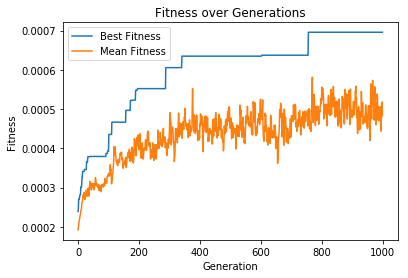

Solution fitness: 0.0006958942240779402
Solution path length: 1437
Solution product sequence:
[0, 1, 4, 6, 13, 15, 3, 11, 8, 7, 17, 9, 14, 12, 5, 10, 2, 16]





In [23]:
# Please keep your parameters for the Genetic Algorithm easily changeable here
population_size = 50
generations = 1000
crossover_probability = 0.3
mutation_probability = 0.1
seed = 225200
persist_file = "./../data/optimal_tsp"

# Setup optimization
tsp_data = TSPData.read_from_file(persist_file)

ga = GeneticAlgorithm(generations, population_size, crossover_probability, mutation_probability, seed)

# Run optimzation and write to file
solution = ga.solve_tsp(tsp_data)
tsp_data.write_action_file(solution, "./../data/tsp_solution.txt")

<div style="background-color:#f1be3e">

We have applied our algorithm on our data with many variations of hyper-parameters (which can be seen below). Considering that, given enough generations, all algorithms converged to the same solution, we regard is as optimal, also from a visual inspection of the solution. We notice that the mean fitness moves closer to the best performing candidate as we decrease the crossover probability, while mutation is also essential in further exploring the space - with a lower mutation probability we need a higher generation count to get to the (assumed) optimal solution.

Using a number of generations of 1000
Using a population size of 20
Using a crossover probability of 0.3
Using a mutation probability of 0.1


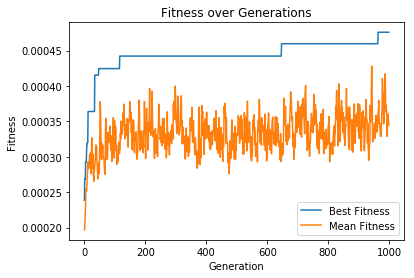

Solution fitness: 0.00047596382674916705
Solution path length: 2101
Solution product sequence:
[13, 4, 6, 1, 15, 3, 0, 8, 12, 17, 7, 14, 11, 9, 5, 10, 2, 16]



Using a number of generations of 1000
Using a population size of 50
Using a crossover probability of 0.7
Using a mutation probability of 0.1


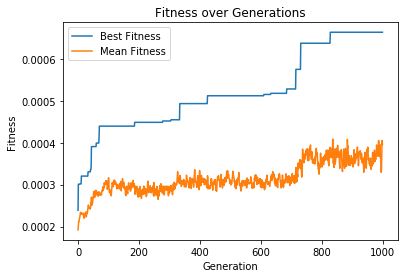

Solution fitness: 0.0006635700066357001
Solution path length: 1507
Solution product sequence:
[1, 0, 4, 13, 6, 3, 15, 8, 9, 14, 7, 17, 11, 12, 5, 10, 2, 16]



Using a number of generations of 1000
Using a population size of 50
Using a crossover probability of 0.7
Using a mutation probability of 0.01


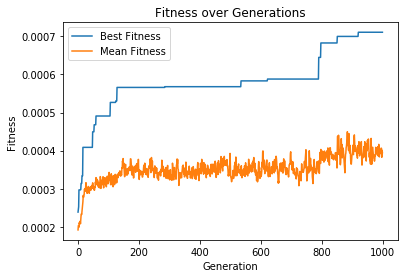

Solution fitness: 0.0007107320540156361
Solution path length: 1407
Solution product sequence:
[0, 1, 6, 4, 13, 3, 15, 8, 11, 14, 17, 7, 9, 12, 5, 10, 2, 16]



Using a number of generations of 10000
Using a population size of 50
Using a crossover probability of 0.7
Using a mutation probability of 0.01


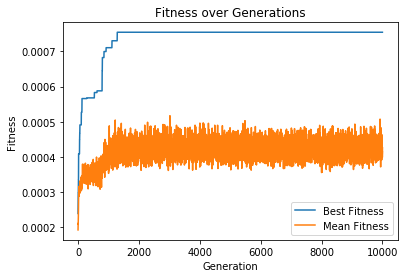

Solution fitness: 0.0007547169811320754
Solution path length: 1325
Solution product sequence:
[0, 1, 6, 4, 13, 15, 3, 8, 17, 7, 9, 14, 11, 12, 5, 10, 2, 16]





[0, 1, 6, 4, 13, 15, 3, 8, 17, 7, 9, 14, 11, 12, 5, 10, 2, 16]

In [24]:
GeneticAlgorithm(
    generations = 1000, 
    pop_size = 20, 
    crossover_probability = 0.3, 
    mutation_probability = 0.1, 
    seed = 225200).solve_tsp(tsp_data)

GeneticAlgorithm(
    generations = 1000, 
    pop_size = 50, 
    crossover_probability = 0.7, 
    mutation_probability = 0.1, 
    seed = 225200).solve_tsp(tsp_data)

GeneticAlgorithm(
    generations = 1000, 
    pop_size = 50, 
    crossover_probability = 0.7, 
    mutation_probability = 0.01, 
    seed = 225200).solve_tsp(tsp_data)

GeneticAlgorithm(
    generations = 10000, 
    pop_size = 50, 
    crossover_probability = 0.7, 
    mutation_probability = 0.01, 
    seed = 225200).solve_tsp(tsp_data)

## Part 2: Path Finding Through Ant Colony Optimization
### 2.2 Observing the Problem

#### Question 11

<div style="background-color:#f1be3e">

The purpose of Ant Colony Optimization (ACO) is to efficiently solve optimization problems, particularly those related to combinatorial optimization. It is typically used when traditional optimization techniques struggle due to the large solution space or the complexity of the problem itself - with a particularity being that the set of feasible solutions is finite. This is particularly useful in routing - finding the optimal path between two points, since we have a finite but sensibly large number of possible routes, given a (finite) graph.

#### Question 12

<div style="background-color:#f1be3e">

We can expect the following topographical features (exemplified via the provided hard maze): 
- Large “rooms” (e.g. the one containing products 11 and 14) where modelling the maze as a graph can get exponentially more difficult, since within such a room we have very large degrees of freedom when it comes to the choices we have to make in our directions (as opposed to when we are simply navigating hallways)
- Long hallways or complex structures ("rooms" with one entry point and large area that lead to nowhere - e.g. upper right of product 14) that can prove to be dead ends, resulting in wasted computation time if explored inefficiently. Additional difficulty can arise if products are actually placed in such places (e.g. product 6), with the optimal strategy being that the robot partly backtracks before taking a different action
- Paralell hallways (e.g. under product 15), where one could easily end up a looping for a while unless some form of memory is used. Loops in general can also prove to be a challenge, there being numerous topographical features which would generate them. A basic dfs would not end up halting its computation.
- Other basic complicating features: twisting hallways, "spikes" coming out of hallways, “rooms” with scattered blocks


#### Question 13

<div style="background-color:#f1be3e">

$\Delta\tau^k_i=Q/L_i$ : The amount of pheromone left on the i-th link by ant k, where $Q$ is a predefined constant for all ants and $L_i$ is the length of the i-th link. 

$\tau_i += \sum_{k}\Delta\tau_i^k$ : On one such link the pheromone accumulates from all ants that pass over it.

Dropping pheromone is a concept fundamental to the functionality of the ant colony optimization algorithm, as it acts as an indirect form of communication between the ants - future explorers will be more likely to follow paths with higher concentration of pheromones. The reason why such a strategy converges to a near-optimal solution is that more pheromone will be dropped on shorter path, so those are more likely to be favored.

#### Question 14

<div style="background-color:#f1be3e">

$\tau_{ij} = (1-\rho) * \tau_{ij}$, where $\tau_{ij}$ is the amount of pheromone on edge $(i,j)$, dependent on $Q$ (the pheromone deposit constant) and $m$ (the amount of ants that pass over the link, stochastically proportional to the total number of ants), and $\rho$ is the evaporation constant, which gives the proportion of pheromone that will evaporate after every iteration.

In the standard approach, two potential issues that can appear - either many routes use a link which is in fact not part of an optimal, shorter tour, or when an ideal, short route contains a very lonk link, unlikely to be explored by the ants. Evaporation encourages exploration, as, without it, pheromone would continue to accumulate, making popular paths more popular, not necessarily due to their quality. By simulating the natural decay of pheromone over time, unexplored routes get higher chances of being explored than they would otherwise.

### 2.3 Implementing the Ant Algorithm

In [103]:
# Class that represents the basic Ant functionality
class StandardAnt:

    """
    Constructor of a StandardAnt taking a Maze and PathSpecification
    @param maze: the Maze where the ant will try to find a route
    @param path_specification: the PathSpecification consisting of a start and an end coordinate
    """
    def __init__(self, maze, path_specification, no_iterations):
        self.maze = maze
        self.start = path_specification.get_start()
        self.end = path_specification.get_end()
        self.current_position = self.start
        self.visited = []
        self.rand = random
        self.no_iterations=no_iterations

    """
    Method that performs a single complete run through the maze by the ant
    @return the route found by the ant
    """
    def find_route(self):
        dx = [1,-1,0,0]
        dy = [0,0,-1,1]
        route = Route(self.start)
        for i in range(self.no_iterations):
            self.visited.append(self.current_position)
            if self.current_position==self.end:
                break
            pheromone = []
            lst=[Direction.north,Direction.south,Direction.east,Direction.west]
            for direction in range(4):
                newCoord=Coordinate(self.current_position.x+dx[direction],self.current_position.y+dy[direction])
                if newCoord not in self.visited:
                    pheromone.append(maze.get_pheromone(newCoord))
                else:
                    pheromone.append(0)
            pheromone=np.array(pheromone)
            if np.sum(pheromone)==0:
                break
            choice=np.random.choice(lst,1,p=pheromone/np.sum(pheromone))[0]
            direction=Direction.dir_to_int(choice)
            self.current_position=Coordinate(self.current_position.x+dx[direction],self.current_position.y+dy[direction])
            route.add(self.current_position)
        return route


In [100]:
# Class that holds all of the maze data.
# This includes the pheromones, the open and blocked tiles in the system,
# and the starting and end coordinates for the ants.
class Maze:

    """
    Constructor of a Maze
    @param walls: array of ints representing the accessible (1) and inaccessible (0) tiles
    @param width: the width (horizontal dimension) of the Maze
    @param length: the length (vertical dimension) of the Maze
    """
    def __init__(self, walls, width, length):
        self.walls = walls
        self.length = length
        self.width = width
        self.start = None
        self.end = None
        self.pheromones=np.zeros((self.width,self.length))
        self.initialize_pheromones()

    """
    Initialize pheromones on all tiles of the Maze
    """
    def initialize_pheromones(self):
        num_ones = 0 
        for i in range(self.length):
            for j in range(self.width):
                num_ones+=self.walls[j][i]!=0
                
        for j in range(self.length):
            for i in range(self.width):
                if self.walls[i][j]==0:
                    self.pheromones[i][j]=0
                else:
                    self.pheromones[i][j]=1/num_ones

    """
    Reset the Maze for a new shortest path problem
    """
    def reset(self):
        self.initialize_pheromones()

    """
    Update the pheromones along a certain route according to a certain Q
    @param route: the route taken by an ant
    @param q: the normalization factor for the amount of dropped pheromone
    """
    def add_pheromone_route(self, route, q):
        l=route.size()
        for x in route.get_route():
            self.pheromones[x.x][x.y] += q/l

    """
    Update pheromones for a list of routes
    @param routes: a list of routes taken by the ants
    @param q: the normalization factor for the amount of dropped pheromone
    """
    def add_pheromone_routes(self, routes, q):
        for r in routes:
            self.add_pheromone_route(r, q)

    """
    Evaporate pheromone
    @param rho: the evaporation factor
    """
    def evaporate(self, rho):
        for j in range(self.length):
            for i in range(self.width):
                if self.walls[i][j]==0:
                    self.pheromones[i][j]=0
                else:
                    self.pheromones[i][j]=rho*self.pheromones[i][j]

    """
    Getter for the width of the maze
    @return the width of the maze
    """
    def get_width(self):
        return self.width

    """
    Getter for the length of the maze
    @return the length of the maze
    """
    def get_length(self):
        return self.length

    """
    Returns a the amount of pheromones on the neighbouring positions (N/S/E/W)
    @param position: the coordinate where we need to check the surrounding pheromones
    @return the pheromones on the neighbouring coordinates.
    """
    def get_surrounding_pheromone(self, position):
        dx = [1,-1,0,0]
        dy = [0,0,-1,1]
        ans = []
        for direction in range(4):
            newPos=Coordinate(pos.x+dx[direction],pos.y+dy[direction])
            ans.append(self.get_pheromone(newPos))
        return ans

    """
    Getter for the pheromones on a specific coordinate.
    If the position is not in bounds returns 0
    @param pos: coordinate for the poition of interest
    @return the amount of pheromone at the specified poition
    """
    def get_pheromone(self, pos):
        if self.in_bounds(pos) is False:
            return 0
        return self.pheromones[pos.x][pos.y]
            

    """
    Check whether a coordinate lies in the bounds of the current maze
    @param position: the position that we need to check
    @return true if the coordinate lies within the current maze
    """
    def in_bounds(self, position):
        return position.x_between(0, self.width) and position.y_between(0, self.length)

    """
    Representation of Maze as defined by the input file format.
    @return the human-readable representation of a maze
    """
    def __str__(self):
        string = ""
        string += str(self.width)
        string += " "
        string += str(self.length)
        string += " \n"
        for y in range(self.length):
            for x in range(self.width):
                string += str(self.walls[x][y])
                string += " "
            string += "\n"
        return string

    """
    Method that builds a maze from a file
    @param file_path: path to the file which stores the maze
    @return a maze object with pheromones initialized to 0s on inaccessible and 1s on accessible tiles
    """
    @staticmethod
    def create_maze(file_path):
        try:
            f = open(file_path, "r")
            lines = f.read().splitlines()
            dimensions = lines[0].split(" ")
            width = int(dimensions[0])
            length = int(dimensions[1])
            
            #make the maze_layout
            maze_layout = []
            for x in range(width):
                maze_layout.append([])
            
            for y in range(length):
                line = lines[y+1].split(" ")
                for x in range(width):
                    if line[x] != "":
                        state = int(line[x])
                        maze_layout[x].append(state)
            print("Ready reading maze file " + file_path)
            return Maze(maze_layout, width, length)
        except FileNotFoundError:
            print("Error reading maze file " + file_path)

In [130]:
# Class representing the complete ACO algorithm.
# Finds shortest path between two points in a maze according to a path specification.
class AntColonyOptimization:

    """
    Constructs a new optimization object using the ant algorithm
    @param maze: the maze (environment) for ants
    @param ants_per_gen: the number of ants per generation (between update of pheromones)
    @param generations: the total number of generations of ants (pheromone updates)
    @param q: the normalization factor for the amount of dropped pheromone
    @param evaporation: the evaporation factor for the pheromones
    """
    def __init__(self, maze, ants_per_gen, generations, q, evaporation):
        self.maze = maze
        self.ants_per_gen = ants_per_gen
        self.generations = generations
        self.q = q
        self.evaporation = evaporation

    """
    Loop that starts the shortest path process
    @param path_specification: description of the route we wish to optimize
    @return the optimized route according to the ACO algorithm
    """
    def find_shortest_route(self, path_specification):
        self.maze.reset()
        shortest_route=-1
        found=0
        for generation in range(self.generations):
            routes = []
            for ants in range(self.ants_per_gen):
                ant=StandardAnt(self.maze,path_specification,1000)
                routee=ant.find_route()
                
                route=routee.get_route()
                if route[len(route)-1]==path_specification.get_end():
                    routes.append(routee)
            for x in routes:
                if found==0:
                    shortest_route=x
                    found=1
                else:
                    if x.shorter_than(shortest_route):
                        shortest_route=x
            self.maze.add_pheromone_routes(routes,self.q)
        return shortest_route
            

In [131]:
# Please keep your parameters for the ACO easily changeable here
gen = 1
no_gen = 100
q = 1600
evap = 0.1

# Construct the optimization objects
maze = Maze.create_maze("./../data/easy_maze.txt")
spec = PathSpecification.read_coordinates("./../data/easy_coordinates.txt")
aco = AntColonyOptimization(maze, gen, no_gen, q, evap)

start_time = int(round(time.time() * 1000))
shortest_route = aco.find_shortest_route(spec)

print("Time taken: " + str((int(round(time.time() * 1000)) - start_time) / 1000.0))
print("Route size: " + str(shortest_route.size()))

shortest_route.write_to_file("./../data/easy_solution.txt")

Ready reading maze file ./../data/easy_maze.txt
Time taken: 0.01


AttributeError: 'int' object has no attribute 'size'

### 2.4 Upgrading Your Ants with Intelligence

#### Question 15

In [ ]:
# Class that represents the intelligent Ant
class IntelligentAnt:

    """
    Constructor of an IntelligentAnt taking a Maze and PathSpecification
    @param maze: the Maze where the ant will try to find a route
    @param path_specification: the PathSpecification consisting of a start and an end coordinate
    """
    def __init__(self, maze, path_specification):
        self.maze = maze
        self.start = path_specification.get_start()
        self.end = path_specification.get_end()
        self.current_position = self.start
        self.rand = random

    """
    Method that performs a single complete run through the maze by the ant
    @return the route found by the ant
    """
    def find_route(self):
        route = Route(self.start)
        pass


<div style="background-color:#f1be3e">

_Put your extra code blocks above (if any) and write your answer here._

### 2.5 Parameter Optimization

#### Question 16

<div style="background-color:#f1be3e">

_Put your code blocks above (if any) and write your answer here._

#### Question 17

<div style="background-color:#f1be3e">

_Put your code blocks above (if any) and write your answer here._

### 2.6 The Final Route

#### Question 18

<div style="background-color:#f1be3e">

_Put your code blocks above (if any) and write your answer here._

### 2.7 Synthesis

#### Question 19

In [ ]:
# Please keep your parameters for the synthesis part easily changeable here
gen = 1
no_gen = 1
q = 1000
evap = 0.1

persist_file = "./../tmp/my_tsp"
tsp_path = "./../data/tsp_products.txt"
coordinates = "./../data/hard_coordinates.txt"

# Construct optimization
maze = Maze.create_maze("./../data/hard_maze.txt")
tsp_data = TSPData.read_specification(coordinates, tsp_path)
aco = AntColonyOptimization(maze, gen, no_gen, q, evap)

# Run optimization and write to file
tsp_data.calculate_routes(aco)
tsp_data.write_to_file(persist_file)

# Read from file and print
tsp_data2 = TSPData.read_from_file(persist_file)
print(tsp_data == tsp_data2)

# Solve TSP using your own paths file
ga = GeneticAlgorithm(generations, population_size)
solution = ga.solve_tsp(tsp_data2)
tsp_data2.write_action_file(solution, "./../data/tsp_solution.txt")

<div style="background-color:#f1be3e">

_Put your extra code blocks above (if any) and write your answer here._

## Part 3: Open Questions
### 3.1 Reflection

#### Question 20

<div style="background-color:#f1be3e">

_Write your answer here._

#### Question 21

<div style="background-color:#f1be3e">

_Write your answer here._

### 3.2 Pen and Paper

#### Question 22

<div style="background-color:#f1be3e">

_Write your answer here. You can also choose to simply include a photo of your solution._

#### Question 23

<div style="background-color:#f1be3e">

_Write your answer here. You can also choose to simply include a photo of your solution._

### 3.3 Division of Work

#### Question 24

<div style="background-color:#f1be3e">


|          Component          |  Name A   |  Name B   |  Name C   |  Name D   |
|-----------------------------|-----------|-----------|-----------|-----------|
| Code (design)               |     A     |     B     |     C     |     D     |
| Code (implementation)       |     A     |     B     |     C     |     D     |
| Code (validation)           |     A     |     B     |     C     |     D     |
| Experiments (execution)     |     A     |     B     |     C     |     D     |
| Experiments (analysis)      |     A     |     B     |     C     |     D     |
| Experiments (visualization) |     A     |     B     |     C     |     D     |
| Report (original draft)     |     A     |     B     |     C     |     D     |
| Report (reviewing, editing) |     A     |     B     |     C     |     D     |

### References

<div style="background-color:#f1be3e">

[1]https://en.wikipedia.org/wiki/Travelling_salesman_problem
[2]https://www.geeksforgeeks.org/travelling-salesman-problem-using-dynamic-programming/
[3]https://proofwiki.org/wiki/Number_of_Hamilton_Cycles_in_Complete_Graph
[4]https://www.redalyc.org/pdf/2652/265219618002.pdf, 3.1